# Graphical analysis of the correlation between landslides and precipitation in the US

This short notebook aims at plotting together data from NOAA precipitation records and data from NASA's Global Landslide Catalog to see how they correlate.

## Introducing the datasets

We will use two datasets in this notebook :
1. The Global Landslide Catalog : It is a CSV file found at [Nasa's open data portal](https://data.nasa.gov/Earth-Science/Global-Landslide-Catalog-Export/dd9e-wu2v). Here is the file description from the website :
>The Global Landslide Catalog (GLC) was developed with the goal of identifying rainfall-triggered landslide events around the world, regardless of size, impacts or location. The GLC considers all types of mass movements triggered by rainfall, which have been reported in the media, disaster databases, scientific reports, or other sources. The GLC has been compiled since 2007 at NASA Goddard Space Flight Center. This is a unique data set with the ID tag “GLC” in the landslide editor.

2. NOAA Global Summary of the Month : Downloaded from [NOAA website](https://www.ncdc.noaa.gov/cdo-web/datasets) as one CSV file per weather station. This gives us the total montly precipitation recorded by selected stations. Since we will work with data from several stations, all the corresponding CSV files have been merged together into 'stations.csv'.

Global Landslide Catalog and stations CSV files will be read into two Pandas DataFrames named respectively ***'lsc'*** (for LandSlide Catalog) and ***'srecords'*** (for stations records).

## Preparing the DataFrames

### 1. LandSlide Catalog DataFrame

In [1]:
import pandas as pd
from math import sqrt
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

%matplotlib inline

lsc=pd.read_csv('Global_Landslide_Catalog_Export.csv',index_col=False,na_filter=False)
lsc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11033 entries, 0 to 11032
Data columns (total 31 columns):
source_name                  11033 non-null object
source_link                  11033 non-null object
event_id                     11033 non-null int64
event_date                   11033 non-null object
event_time                   11033 non-null object
event_title                  11033 non-null object
event_description            11033 non-null object
location_description         11033 non-null object
location_accuracy            11033 non-null object
landslide_category           11033 non-null object
landslide_trigger            11033 non-null object
landslide_size               11033 non-null object
landslide_setting            11033 non-null object
fatality_count               11033 non-null object
injury_count                 11033 non-null object
storm_name                   11033 non-null object
photo_link                   11033 non-null object
notes                    

The Global Landslide Catalog comes with 11033 rows - each one being a landslide event - and 31 columns from which we only want to keep ***'event_date'***, ***'longitude'*** and ***'latitude'***. We also need to turn ***'event_date'*** into a DateTime object so that we can group data by month and year. 

From the 11033 rows, we only want to keep the events which occured in 2007 and later (see dataset introduction) and were triggered by precipitation.

The resulting DataFrame will be named ***'lsc_sub'*** for *LandSlide Catalog Subset*.

#### 1.a. Splitting 'event_date' into day / month / year

In [2]:
lsc['event_date'].head()

0    08/01/2008 12:00:00 AM
1    01/02/2009 02:00:00 AM
2    01/19/2007 12:00:00 AM
3    07/31/2009 12:00:00 AM
4    10/16/2010 12:00:00 PM
Name: event_date, dtype: object

In [3]:
lsc['event_date']=pd.to_datetime(lsc['event_date'],format='%m/%d/%Y %I:%M:%S %p')
lsc['year']=lsc['event_date'].dt.year
lsc['month']=lsc['event_date'].dt.month
lsc['day']=lsc['event_date'].dt.day

#### 1.b. Filtering precipitation related landslides

Let's make a list of the different landslide triggers mentionned in the Global Landslide Catalog and count the number of corrresponding events. We will only keep those related to precipitation.

In [57]:
triggers=lsc['landslide_trigger'].unique()
for index,trigger in enumerate(triggers):
    print(index,trigger,'\t',lsc[lsc['landslide_trigger']==trigger].shape[0])

0 rain 	 2592
1 downpour 	 4680
2 monsoon 	 129
3 tropical_cyclone 	 561
4 unknown 	 1691
5 continuous_rain 	 748
6 dam_embankment_collapse 	 12
7 no_apparent_trigger 	 44
8  	 23
9 other 	 26
10 leaking_pipe 	 10
11 construction 	 82
12 snowfall_snowmelt 	 135
13 mining 	 93
14 flooding 	 75
15 earthquake 	 89
16 freeze_thaw 	 41
17 volcano 	 1
18 vibration 	 1


In [67]:
weather_related_triggers=triggers[[0,1,2,3,5,12,14]]
lsc['prcp_related']=lsc['landslide_trigger'].isin(weather_related_triggers)

#### 1.c. Building the subset

In [59]:
subset_columns=['year','month','day','longitude','latitude']
lsc_sub=lsc.loc[(lsc['year']>=2007)&(lsc['prcp_related']==True),subset_columns]
lsc_sub.reset_index(inplace=True,drop=True)
lsc_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8882 entries, 0 to 8881
Data columns (total 5 columns):
year         8882 non-null int64
month        8882 non-null int64
day          8882 non-null int64
longitude    8882 non-null float64
latitude     8882 non-null float64
dtypes: float64(2), int64(3)
memory usage: 347.0 KB


### 2.Weather stations records

As mentionned before, all the weather stations records have been put in a single file ***'stations.csv'*** and will be read into a Pandas DataFrame ***srecords***.
Stations were selected according to 2 criteria:
1. Location within a landslide-prone area
2. Good data coverage from 2007 to 2017 (last year of compilation for the Global Landslide Catalog)

Here is the first row of data for each station:

In [60]:
srecords=pd.read_csv('stations.csv',index_col=0)
srecords.groupby('NAME').first()

,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP
NAME,,,,,,
"BRIDGEVILLE 1.4 SW, PA US",US1PAAL0001,40.34170,-80.12290,310.0,2007-01,4.00
"CHINO AIRPORT, CA US",USW00003179,33.97528,-117.63611,198.1,2007-01,0.11
"EAST JEWETT, NY US",USC00302366,42.23560,-74.14330,606.9,2007-01,2.97
"HAZARD WATER WKS, KY US",USC00153714,37.24710,-83.18170,268.2,2007-01,3.94
"HIDDEN LAKE, ID US",USS0016A12S,48.89000,-116.76000,1536.2,2007-01,7.89
"JACKWHACKER GULCH, CO US",USS0005K26S,39.57000,-105.80000,3340.6,2007-01,2.00
"LANDSBURG, WA US",USC00454486,47.37660,-121.96130,163.1,2007-01,6.56
"LEABURG 1 SW, OR US",USC00354811,44.10130,-122.68860,205.7,2007-01,7.57
"MOFFETT FEDERAL AIRFIELD, CA US",USW00023244,37.40583,-122.04806,11.9,2007-01,0.83


We want to convert the ***'DATE'*** column into a DateTime object to extract the month and the year. We also want to convert the precipitation (***'PRCP'***) column to centimeters instead of inches. *NOAA website actually allows user to choose a prefered unit system but this possibility was missed.*

In [61]:
srecords['DATE']=pd.to_datetime(srecords['DATE'],format='%Y-%m')
srecords['MONTH']=srecords['DATE'].dt.month
srecords['YEAR']=srecords['DATE'].dt.year
srecords['PRCP']*=2.54

In order to make ***'srecords'*** lighter and the code easier to write and (hopefully) to read, we make another DataFrame  ***'stations'*** which will only contain stations geographical data.
Then, for each station, we associate a radius of analysis in degree. This will be used to *'fine-select'* the landslides for plotting.

In [62]:
stations=srecords.groupby('NAME').first()
stations.reset_index(inplace=True)
stations.drop(['DATE','PRCP','MONTH','YEAR'],axis=1,inplace=True)

radii={0:1, 1:3, 2:3, 3:3, 4:3, 5:3, 6:2, 7:1.5, 8:3, 9:2}

for station,radius in radii.items():
     stations.loc[station,'RADIUS']=radius
        
stations

,NAME,STATION,LATITUDE,LONGITUDE,ELEVATION,RADIUS
0,"BRIDGEVILLE 1.4 SW, PA US",US1PAAL0001,40.34170,-80.12290,310.0,1.0
1,"CHINO AIRPORT, CA US",USW00003179,33.97528,-117.63611,198.1,3.0
2,"EAST JEWETT, NY US",USC00302366,42.23560,-74.14330,606.9,3.0
3,"HAZARD WATER WKS, KY US",USC00153714,37.24710,-83.18170,268.2,3.0
4,"HIDDEN LAKE, ID US",USS0016A12S,48.89000,-116.76000,1536.2,3.0
5,"JACKWHACKER GULCH, CO US",USS0005K26S,39.57000,-105.80000,3340.6,3.0
6,"LANDSBURG, WA US",USC00454486,47.37660,-121.96130,163.1,2.0
7,"LEABURG 1 SW, OR US",USC00354811,44.10130,-122.68860,205.7,1.5
8,"MOFFETT FEDERAL AIRFIELD, CA US",USW00023244,37.40583,-122.04806,11.9,3.0
9,"SPANISH FORK POWER HOUSE, UT US",USC00428119,40.08003,-111.60460,1438.7,2.0


## Mapping the landslides and stations

We can now map all the landslides around the world from 2007 to 2017 and make a detailed map of the United States with the stations and their area of analysis!

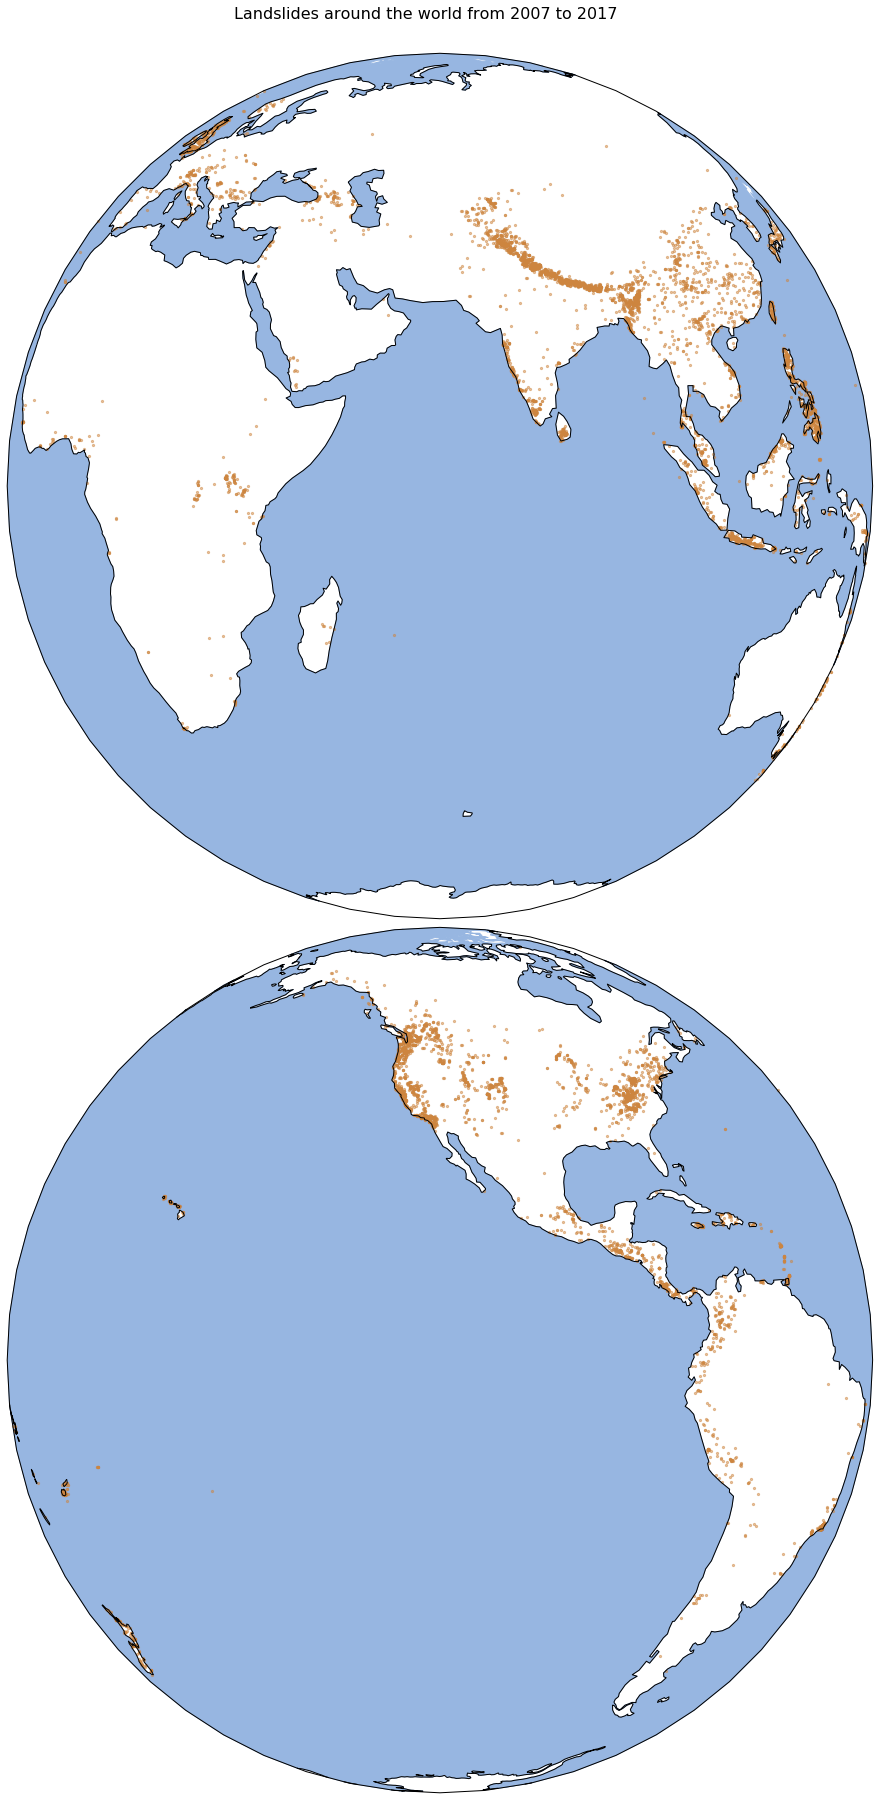

In [68]:
#mapping landslides
#creating the figure and geoaxes
fig_map=plt.figure(figsize=(16,32))
fig_map.suptitle('Landslides around the world from 2007 to 2017',fontsize=16,y=0.9)
gs=fig_map.add_gridspec(nrows=2,ncols=1,wspace=0.05,hspace=0.01)

ax_map1=fig_map.add_subplot(gs[0,0],
                            projection=ccrs.Orthographic(central_longitude=64)
                           )
ax_map1.coastlines()
ax_map1.set_global()
ax_map1.add_feature(cfeature.OCEAN)

ax_map2=fig_map.add_subplot(gs[1,0],
                            projection=ccrs.Orthographic(central_longitude=64+180)
                           )
ax_map2.coastlines()
ax_map2.set_global()
ax_map2.add_feature(cfeature.OCEAN)

#mapping the landslides
on_face1=(lsc_sub['longitude'].between(64-90,64+90))

x_face1=lsc_sub.loc[on_face1,'longitude']
y_face1=lsc_sub.loc[on_face1,'latitude']
x_face2=lsc_sub.loc[~on_face1,'longitude']
y_face2=lsc_sub.loc[~on_face1,'latitude']

ax_map1.scatter(x_face1,y_face1,s=5,c='peru',alpha=0.5
                ,transform=ccrs.PlateCarree())

ax_map2.scatter(x_face2,y_face2,s=5,c='peru',alpha=0.5,label='landslide',
                transform=ccrs.PlateCarree()
               )

plt.show()

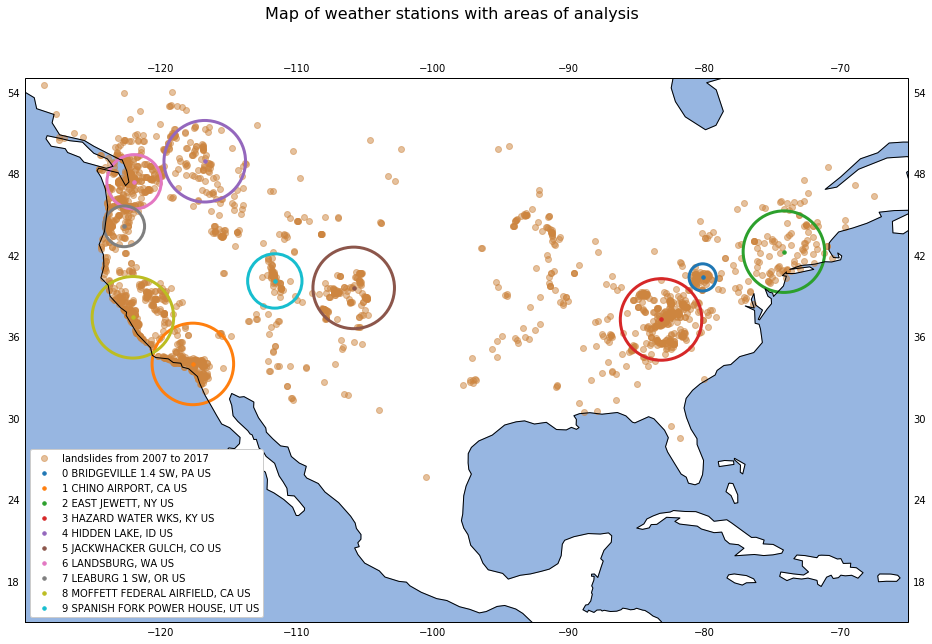

In [70]:
#mapping stations

#color list
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
        'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

#preparing figure and axe
fig_z1=plt.figure(figsize=(16,10))
fig_z1.suptitle('Map of weather stations with areas of analysis',fontsize=16)

ax_z1=fig_z1.add_subplot(1,1,1,projection=ccrs.PlateCarree())

gl=ax_z1.gridlines(ccrs.PlateCarree(),draw_labels=True)
gl.xlines=False
gl.ylines=False

(lon0,lon1,lat0,lat1)=(-130,-65,25,55)
limits=(lon0,lon1,lat0-10,lat1)
ax_z1.set_extent(limits,ccrs.PlateCarree())

ax_z1.coastlines()
ax_z1.add_feature(cfeature.OCEAN)

#mapping landslides
x=lsc_sub.loc[(lsc_sub['longitude'].between(lon0,lon1))&(lsc_sub['latitude'].between(lat0,lat1)),'longitude']
y=lsc_sub.loc[(lsc_sub['longitude'].between(lon0,lon1))&(lsc_sub['latitude'].between(lat0,lat1)),'latitude']

ax_z1.scatter(x,y,c='peru',alpha=0.5,label='landslides from 2007 to 2017')

#mapping the stations with area of analysis
s_on_map=(stations['LONGITUDE'].between(lon0,lon1))&(stations['LATITUDE'].between(lat0,lat1))

for index,station in stations[s_on_map].iterrows():
    x=station['LONGITUDE']
    y=station['LATITUDE']       
    ax_z1.scatter(x,y,s=12,label=str(index)+' '+station['NAME'],c=colors[index],transform=ccrs.PlateCarree())
    ax_z1.add_patch(mpatches.Circle(xy=[x,y],radius=station['RADIUS'],transform=ccrs.PlateCarree(),
                                     color=colors[index],fill=False,linewidth=3))
    
    ax_z1.legend(loc='lower left',framealpha=1)

plt.show()

## Correlation between precipitation and landslides

In [64]:
def setupplot(ax,xticks,title):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(xticks)
    ax.set_title(title)
    
def analyse(snum):
    
    #Preparing filters and figure
    sname=stations.loc[snum,'NAME']
    slat=stations.loc[snum,'LATITUDE']
    slon=stations.loc[snum,'LONGITUDE']
    radius=stations.loc[snum,'RADIUS']
    saround=(((lsc_sub['longitude']-slon)**2+(lsc_sub['latitude']-slat)**2).apply(sqrt))<=radius
    
    fig=plt.figure(figsize=(16,24))
    fig.suptitle('Correlation between precipitation and landslides around '+sname,fontsize=16,y=0.92)
    gs=fig.add_gridspec(nrows=4,ncols=2,hspace=0.3)
    
    # Mapping the station and the surrounding landslides      
    ax1=fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree())
    gl=ax1.gridlines(ccrs.PlateCarree(),draw_labels=True)
    gl.xlines=False
    gl.ylines=False
    
    ax1.add_feature(cfeature.STATES)
    ax1.add_feature(cfeature.OCEAN)
    ax1.coastlines()
    ax1.set_extent((slon-18,slon+18,slat-5,slat+5))
    
    x=lsc_sub.loc[saround,'longitude']
    y=lsc_sub.loc[saround,'latitude']
    
    ax1.scatter(x,y,c='peru',alpha=0.5,label=str(x.shape[0])+' landslides from 2007 to 2017',
                transform=ccrs.PlateCarree())
    ax1.scatter(slon,slat,c='black',transform=ccrs.PlateCarree())
    ax1.text(slon,slat,sname,fontsize=12)
    
    ax1.legend(loc='upper left',framealpha=1)
    
    # Plotting seasonality of precipitation and landslides
    lscount_per_month=(lsc_sub[saround]
                       .groupby('month')
                       .size()
                      )
    prcp_per_month=(srecords[srecords['NAME']==stations.loc[snum,'NAME']]
                    .groupby('MONTH')
                    .sum()
                    ['PRCP']
                   )
    ax2=fig.add_subplot(gs[1,0])
    ax2.plot(lscount_per_month,c='peru',label='landslides')
    ax2.plot(prcp_per_month,c='dodgerblue',label='precipitation')
    setupplot(ax2,range(1,13),'Seasonality of landslides and precipitations')
    
    # Plotting correlation between landslide occurrences and precipitation
    # Counting landslides
    lscount=(lsc_sub[saround]
             .groupby(['year','month'])
             .size()
            )
    #Summing precipitation
    prcp=(srecords[srecords['NAME']==stations.loc[snum,'NAME']]
          .groupby(['YEAR','MONTH'])
          .sum()
          ['PRCP']
         )
    #Gathering landslides and precipitation in ls_prcp
    years_months=[range(2007,2018),range(1,13)]
    years_months_index=pd.MultiIndex.from_product(years_months,names=['year','month'])
    ls_prcp=pd.DataFrame(index=years_months_index,columns=['ls_count','prcp'])
    ls_prcp['ls_count']=lscount
    ls_prcp['prcp']=prcp
    ls_prcp.loc[ls_prcp['ls_count'].isnull(),'ls_count']=0
    ls_prcp.index=pd.date_range('2007-01-01','2017-12-01',freq='MS')
    correlation=round(ls_prcp.corr().loc['prcp','ls_count'],2)
    
    ax3=fig.add_subplot(gs[1,1])
    sns.scatterplot(ls_prcp['prcp'],ls_prcp['ls_count'],hue='m'+ls_prcp.index.month.astype(str),
                   palette=sns.hls_palette(12, l=0.5, s=.8))
    sns.despine()
    ax3.set_ylabel('Total of landslides')
    ax3.set_xlabel('Sum of precipitation in cm')
    ax3.set_title('Landslides / precipitation scatter plot\nCorrelation : '+str(correlation))
    ax3.legend(loc='upper left',title='Month')
    
    ax4=fig.add_subplot(gs[2,:])
    ax4.plot(ls_prcp['prcp'],c='dodgerblue',label='Sum of precipitation in cm')
    ax4.plot(ls_prcp['ls_count'],c='peru',label='Total of landslides')
    setupplot(ax4,
              pd.date_range('2007-01-01','2017-12-01',freq='YS'),
              'Landslides and precipitation from 2007 to 2017'
             )
    ax4.legend(loc='upper left')
            
    #return graphical analysis and ls_prcp DataFrame
    fig.savefig(station['NAME'],format='pdf',papertype='a4')
    return(fig, ls_prcp)

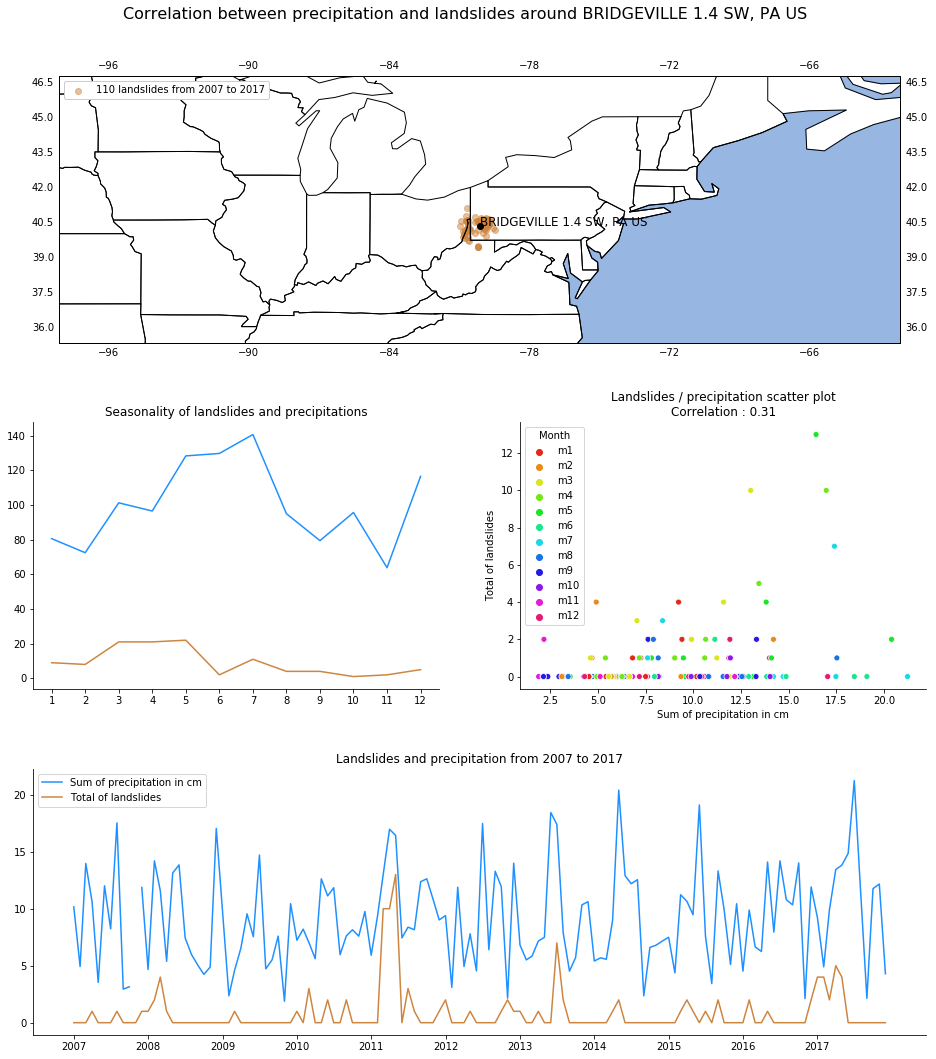

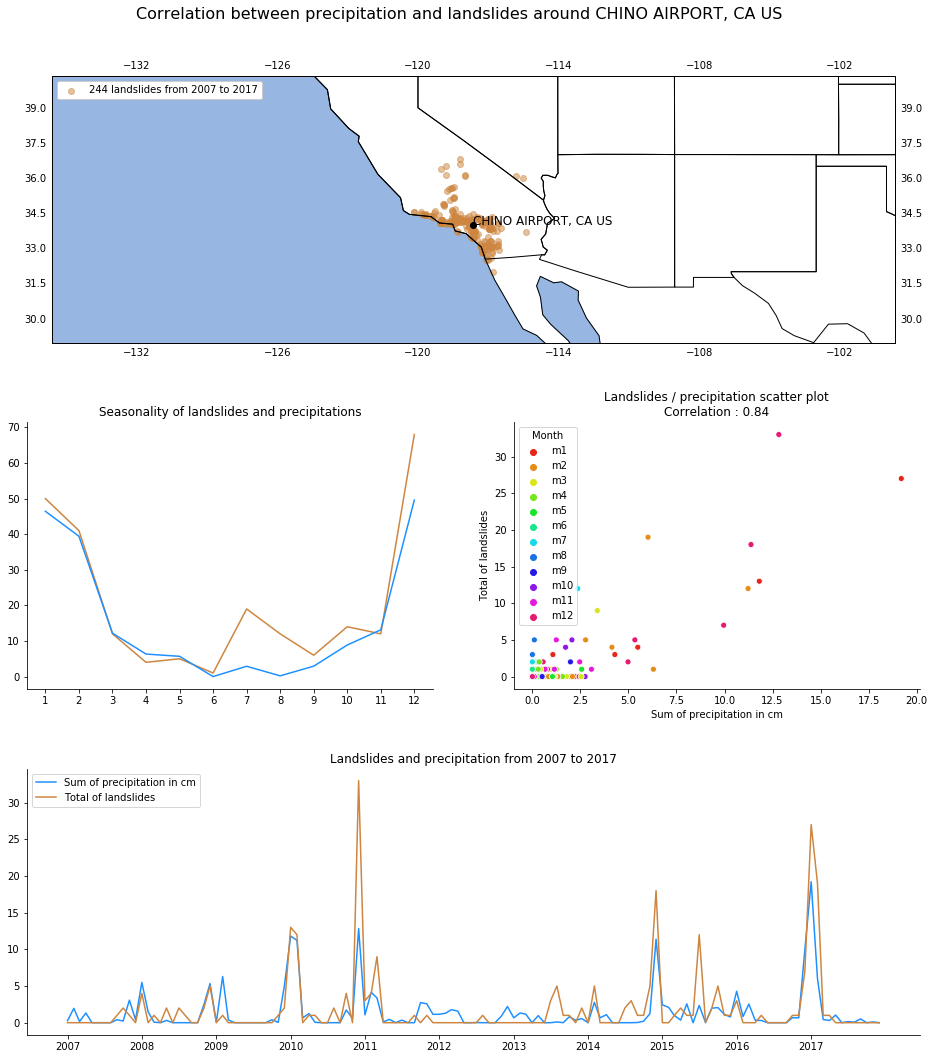

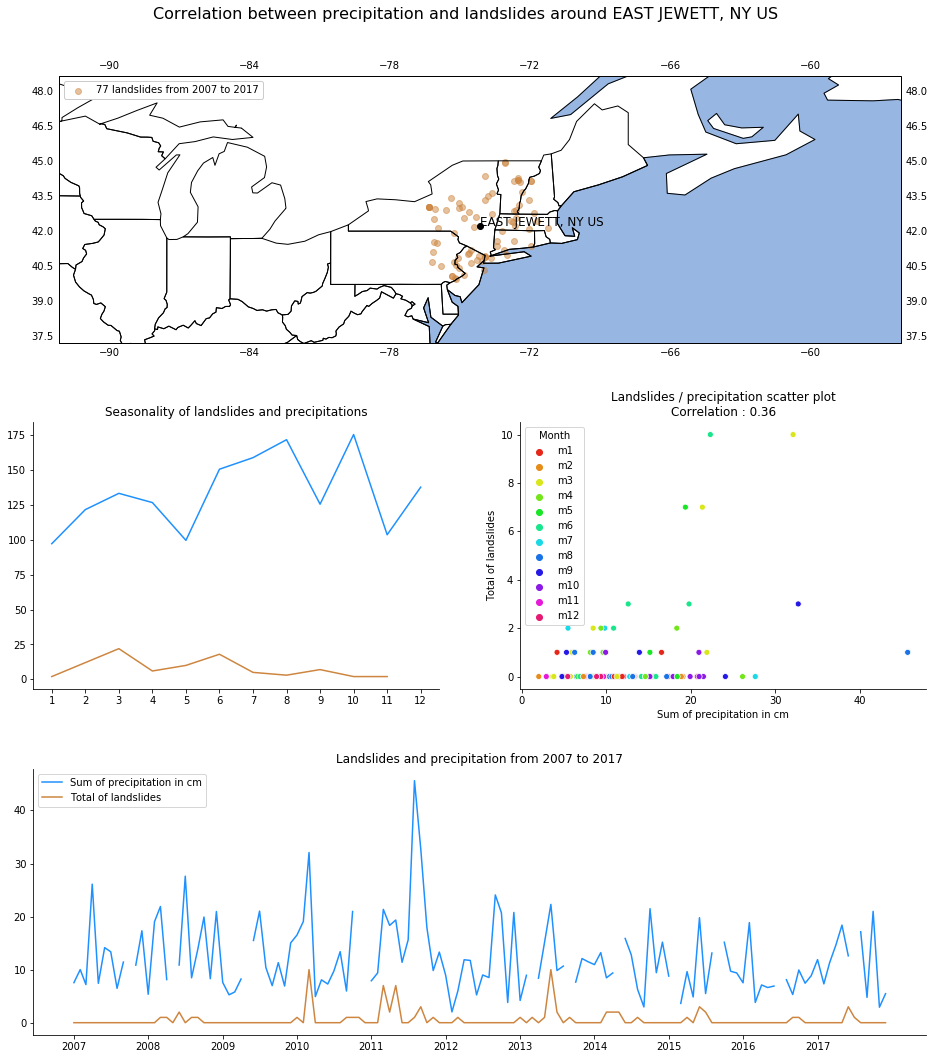

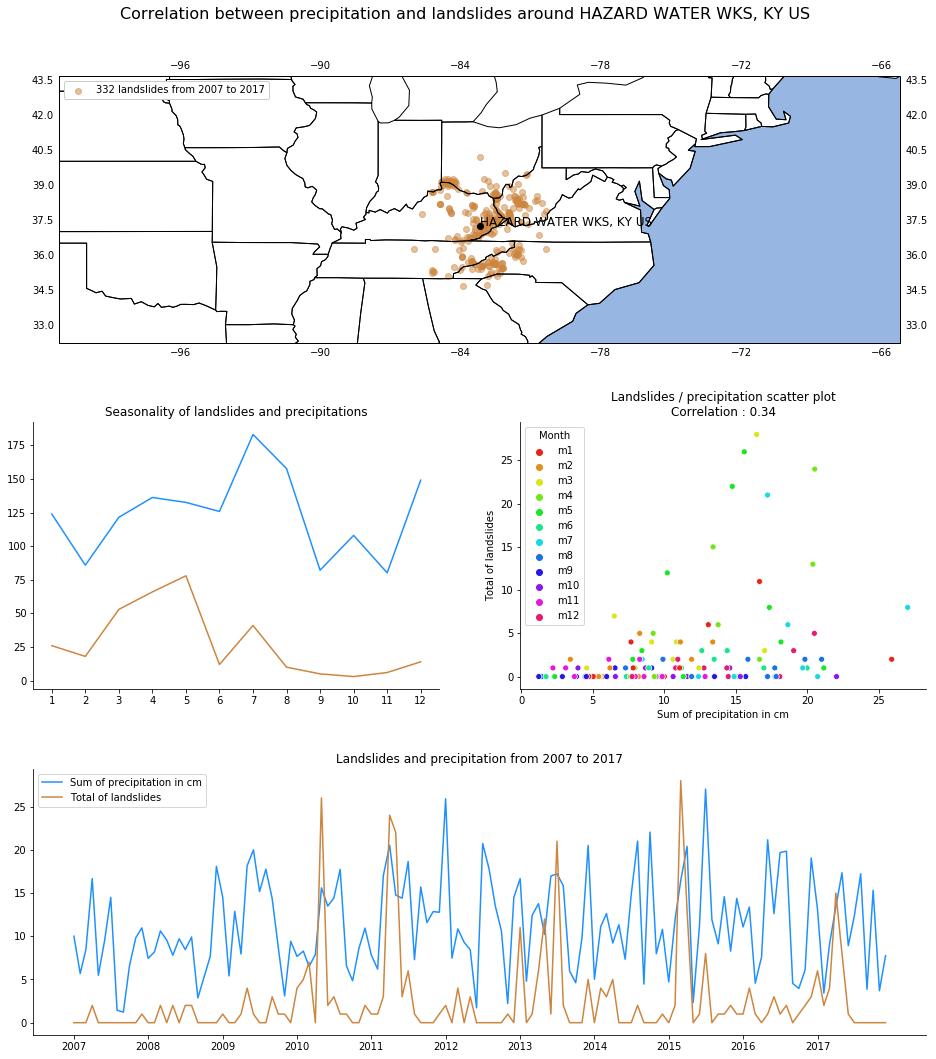

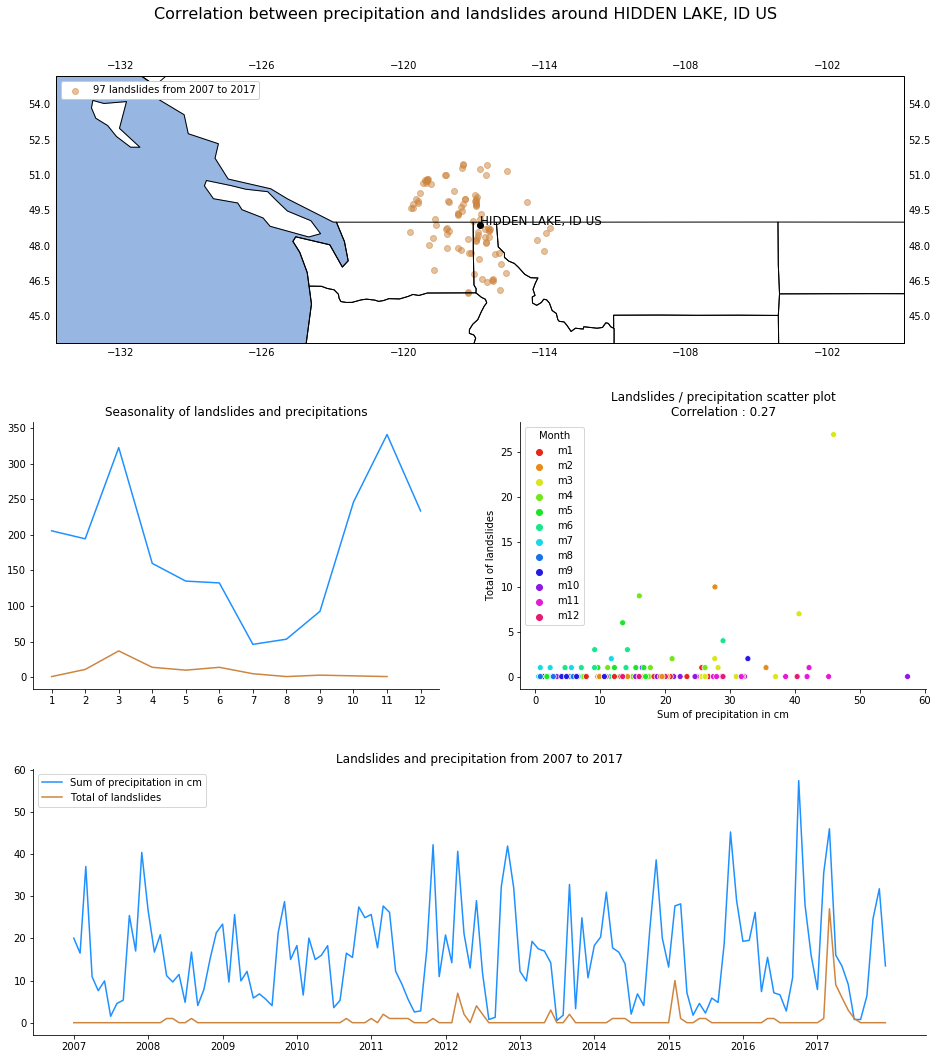

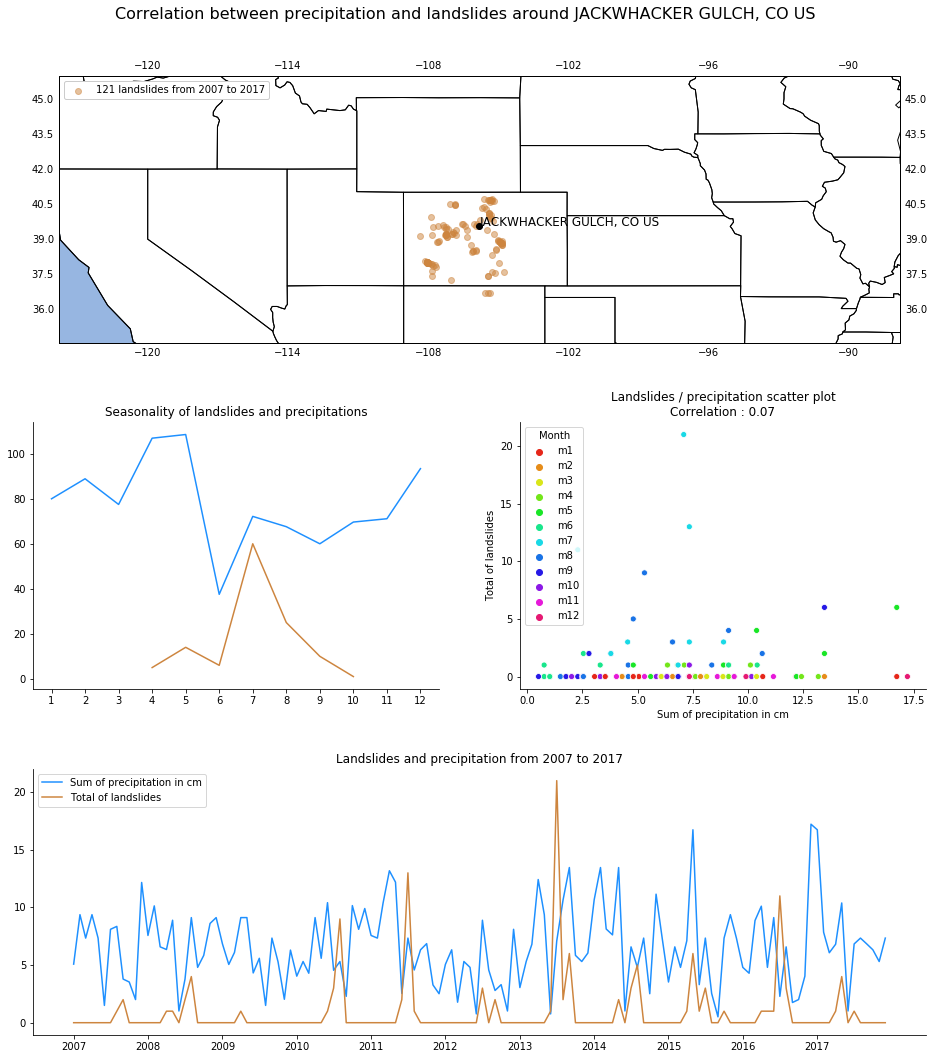

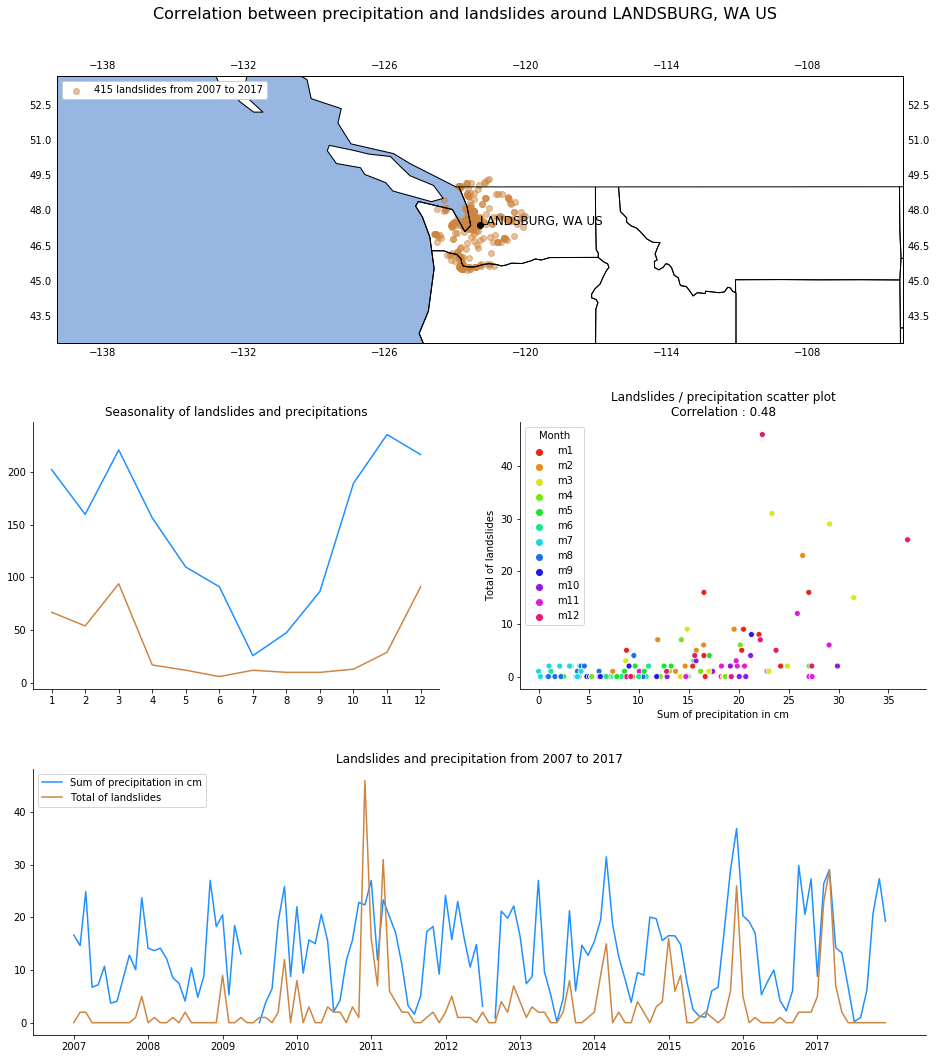

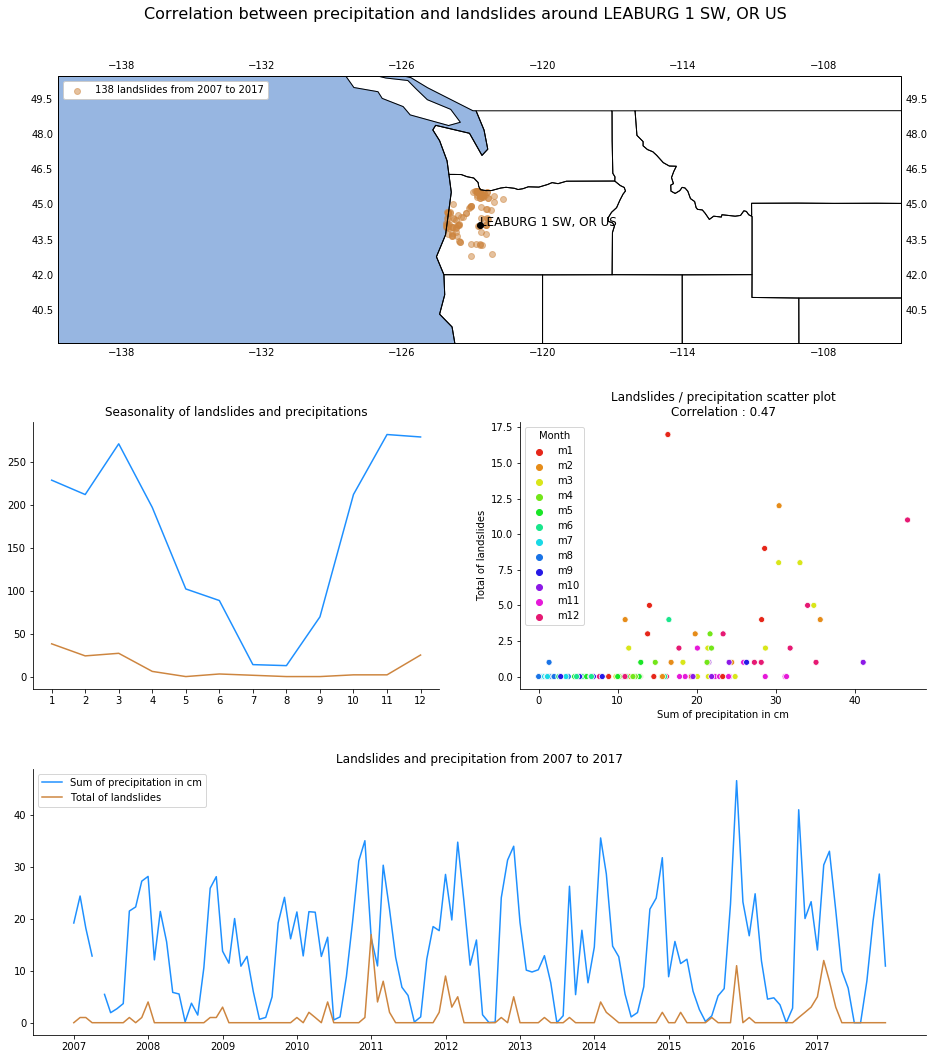

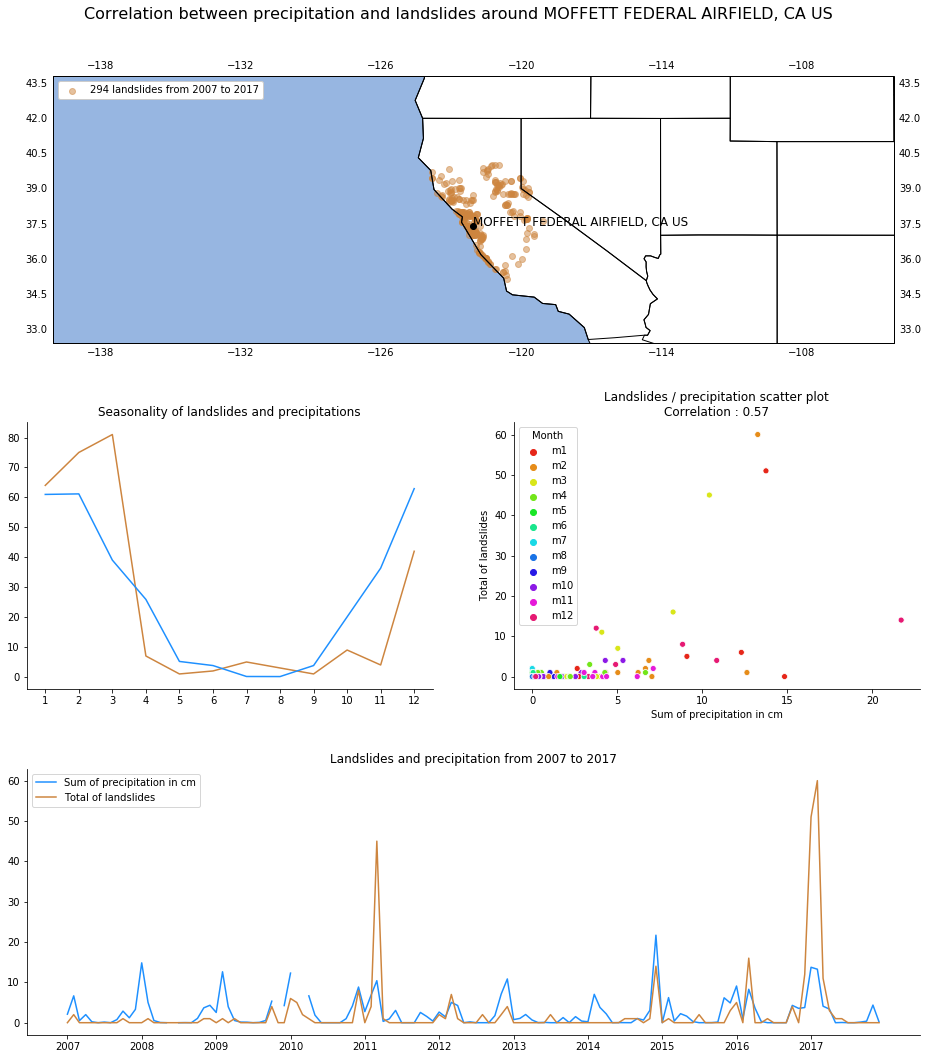

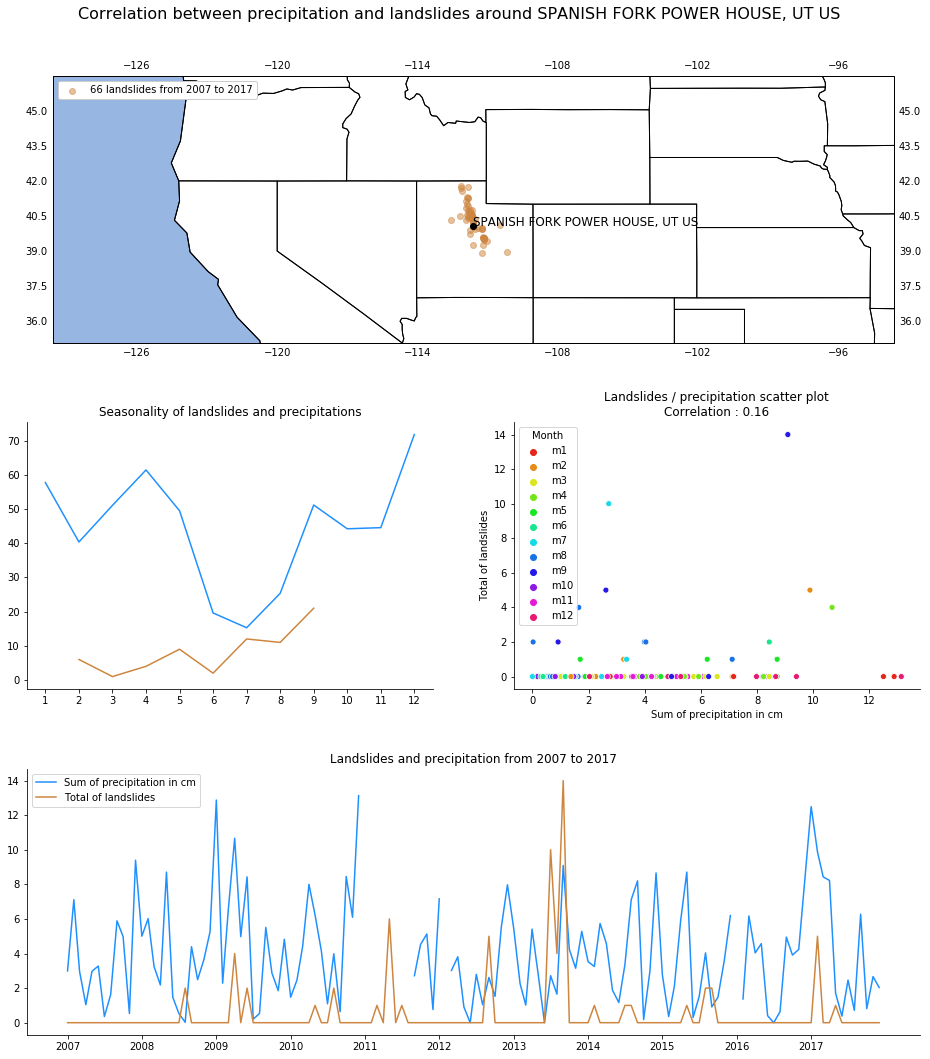

In [71]:
for index,station in stations.iterrows():
    analyse(index)
